# Effect of UBI on Supplemental Poverty Measure amid Covid-19 recession

Simulate different resource reductions in response to a recession.

## Setup
### Imports

In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

### Other

In [2]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
mdf.set_plot_style()

--2020-03-17 14:06:15--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2020-03-17 14:06:16--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.196.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf.1’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.05s   

2020-03-17 14:06:16 (2.97 MB/s) - ‘Roboto-Regular.ttf.1’ saved [145348/145348]



### Load data

Looks for the 2019 March Supplement in a `~/data` folder.

In [3]:
ASEC_F = '~/data/asec/2019/pppub19.csv'

Otherwise download from https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html.

In [4]:
if not os.path.isfile(os.path.expanduser(ASEC_F)):
    !mkdir ~/data
    !wget -O ~/data/asecpub19csv.zip http://thedataweb.rm.census.gov/pub/cps/march/asecpub19csv.zip
    !unzip ~/data/asecpub19csv.zip -d ~/data

In [5]:
SPM_COLS = ['povthreshold', 'resources', 'poor', 'numper', 'numkids',
            'numadults', 'id', 'weight']
OTHER_COLS = ['A_AGE', 'MARSUPWT', 'PRCITSHP']
cols = ['SPM_' + i.upper() for i in SPM_COLS] + OTHER_COLS

In [6]:
raw = pd.read_csv(ASEC_F, usecols=cols)

## Preprocess

In [7]:
df = raw.copy(deep=True)

In [8]:
df.columns = map(str.lower, df.columns)

Add true weight by dividing by 100.

In [9]:
df['w'] = df.marsupwt / 100.
df['spm_w'] = df.spm_weight / 100.

Add citizenship indicator, per https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar19.pdf.

In [10]:
df['is_citizen'] = df.prcitshp != 5

In [11]:
df['is_kid'] = df.a_age < 18
df['is_adult'] = df.a_age >= 18
df['is_kid_citizen'] = df.is_citizen & df.is_kid
df['is_adult_citizen'] = df.is_citizen & df.is_adult

Number of citizens per SPM unit.

In [12]:
spmu = df.groupby('spm_id')[['is_kid', 'is_adult',
                             'is_kid_citizen', 'is_adult_citizen']].sum()

In [13]:
spmu.columns = ['spm_nu18', 'spm_n18',
                'spm_numkidcitizens', 'spm_numadultcitizens']

In [14]:
df = df.merge(spmu, on='spm_id')

Merge in other SPM unit characteristics.

In [15]:
spmu_raw = df[['spm_resources', 'spm_povthreshold', 'spm_id',
               'spm_w']].drop_duplicates()

In [16]:
spmu = spmu.join(spmu_raw.set_index('spm_id'))

In [17]:
spmu

,spm_nu18,spm_n18,spm_numkidcitizens,spm_numadultcitizens,spm_resources,spm_povthreshold,spm_w
spm_id,,,,,,,
4001,0.0,1.0,0.0,1.0,12961,10080,2031.67
6001,0.0,1.0,0.0,1.0,13292,11483,1232.04
7001,0.0,1.0,0.0,1.0,10232,11483,1209.17
8001,0.0,2.0,0.0,2.0,20084,16190,1146.23
13001,0.0,1.0,0.0,1.0,21534,11546,1587.98
...,...,...,...,...,...,...,...
94629001,0.0,1.0,0.0,0.0,70975,17526,444.01
94630001,0.0,2.0,0.0,2.0,28273,20304,412.47
94631001,4.0,2.0,4.0,2.0,40796,46249,515.55


## Analysis

Percent citizen.

In [18]:
mdf.weighted_mean(df, 'is_citizen', 'w')

0.9274755680739586

In [19]:
mdf.weighted_mean(df[df.a_age < 18], 'is_citizen', 'w')

0.9718902678491073

In [20]:
mdf.weighted_mean(df[df.a_age >= 18], 'is_citizen', 'w')

0.9143950894716393

In [21]:
def rounded_pct(x):
    print(str((x * 100).round(1)) + '%')

In [22]:
def print_pov(df, weight='w'):
    rounded_pct(mdf.weighted_mean(df, 'spm_poor', weight))

In [23]:
def ubi_pov_rate(resource_cut=0, ubi_adult=0, ubi_kid=0,
                 ubi_adult_citizen=0, ubi_kid_citizen=0):
    """ Calculate SPM poverty rate in billions, given a certain cut in
        baselin resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid: UBI per child.
        ubi_adult_citizen: UBI per adult citizen.
        ubi_kid_citizen: UBI per child citizen.
    
    Returns:
        Poverty rate (between 0 and 1).
    """
    resources = (
        df.spm_resources * (1 - resource_cut) + 
        ubi_adult * df.spm_n18 +
        ubi_kid * df.spm_nu18 +
        ubi_adult_citizen * df.spm_numadultcitizens +
        ubi_kid_citizen * df.spm_numkidcitizens)
    is_pov = resources < df.spm_povthreshold
    return (is_pov * df.w).sum() / df.w.sum()

**TODO** This doesn't match the SPM unit poverty gap.

https://gist.github.com/MaxGhenis/1db39c777493b5bc9279c0550c247006

In [24]:
def ubi_pov_gap_b(resource_cut=0, ubi_adult=0, ubi_kid=0,
                  ubi_adult_citizen=0, ubi_kid_citizen=0):
    """ Calculate SPM poverty gap in billions, given a certain cut in baseline
        resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid: UBI per child.
        ubi_adult_citizen: UBI per adult citizen.
        ubi_kid_citizen: UBI per child citizen.
    
    Returns:
        Poverty gap in billions.
    """
    # Use spmu dataset.
    resources = (
        spmu.spm_resources * (1 - resource_cut) + 
        ubi_adult * spmu.spm_n18 +
        ubi_kid * spmu.spm_nu18 +
        ubi_adult_citizen * spmu.spm_numadultcitizens +
        ubi_kid_citizen * spmu.spm_numkidcitizens)
    pov_gap = np.maximum(spmu.spm_povthreshold - resources, 0)
    return (pov_gap * spmu.spm_w).sum() / 1e9

In [25]:
def ubi_pov_gap_pp(resource_cut=0, ubi_adult=0, ubi_kid=0,
                   ubi_adult_citizen=0, ubi_kid_citizen=0):
    """ Calculate SPM per-person poverty gap, given a certain cut in baseline
        resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid: UBI per child.
        ubi_adult_citizen: UBI per adult citizen.
        ubi_kid_citizen: UBI per child citizen.
    
    Returns:
        Poverty gap divided by total population.
    """
    return (1e9 * ubi_pov_gap_b(resource_cut, ubi_adult, ubi_kid,
                                ubi_adult_citizen, ubi_kid_citizen) / 
            df.w.sum())

In [26]:
def ubi_pov_gap_per_pov(resource_cut=0, ubi_adult=0, ubi_kid=0,
                        ubi_adult_citizen=0, ubi_kid_citizen=0):
    """ Calculate SPM per-person-in-poverty poverty gap, given a certain cut
        in baseline resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid: UBI per child.
        ubi_adult_citizen: UBI per adult citizen.
        ubi_kid_citizen: UBI per child citizen.
    
    Returns:
        Poverty gap divided by total population in poverty.
    """
    return (ubi_pov_gap_pp(resource_cut, ubi_adult, ubi_kid,
                           ubi_adult_citizen, ubi_kid_citizen) / 
            ubi_pov_rate(resource_cut, ubi_adult, ubi_kid,
                         ubi_adult_citizen, ubi_kid_citizen))

In [27]:
def ubi_cost_b(ubi_adult=0, ubi_kid=0,
               ubi_adult_citizen=0, ubi_kid_citizen=0):
    ubi_adult_cost = (ubi_adult * df.is_adult * df.w).sum()
    ubi_kid_cost = (ubi_kid * df.is_kid * df.w).sum()
    ubi_adult_citizen_cost = (
        ubi_adult_citizen * df.is_adult_citizen * df.w).sum()
    ubi_kid_citizen_cost = (ubi_kid_citizen * df.is_kid_citizen * df.w).sum()
    return (ubi_adult_cost + ubi_kid_cost +
            ubi_adult_citizen_cost + ubi_kid_citizen_cost) / 1e9

## Baseline

In [28]:
print_pov(df)

12.7%


In [29]:
print_pov(df[df.is_citizen])

11.9%


In [30]:
print_pov(df[~df.is_citizen])

23.7%


In [31]:
print_pov(df[df.is_adult])

12.5%


In [32]:
print_pov(df[df.is_kid])

13.6%


In [33]:
ubi_pov_gap_b()

169.98995792551003

In [34]:
ubi_pov_gap_pp()

524.0847744869411

In [35]:
ubi_pov_gap_per_pov()

4115.75580934004

## Resource cut, no UBI

Simulate for each percentage point cut between 0 and 10.

In [36]:
CUTS = np.arange(11) / 100

In [37]:
POP_M = 327.2

In [38]:
cuts = pd.DataFrame(index=CUTS)
cuts['pov_rate'] = cuts.index.map(lambda x: ubi_pov_rate(resource_cut=x))
cuts['pov_gap_b'] = cuts.index.map(lambda x: ubi_pov_gap_b(resource_cut=x))
cuts['pov_m'] = cuts.pov_rate * POP_M

In [39]:
cuts

,pov_rate,pov_gap_b,pov_m
0.00,0.127336,169.989958,41.664410
0.01,0.130368,172.048194,42.656338
0.02,0.133005,174.184895,43.519106
0.03,0.136044,176.399871,44.513513
0.04,0.138870,178.695124,45.438231
0.05,0.142090,181.080439,46.491921
0.06,0.145322,183.553945,47.549216
0.07,0.148721,186.132003,48.661595
0.08,0.152685,188.824903,49.958619
0.09,0.155851,191.625085,50.994585


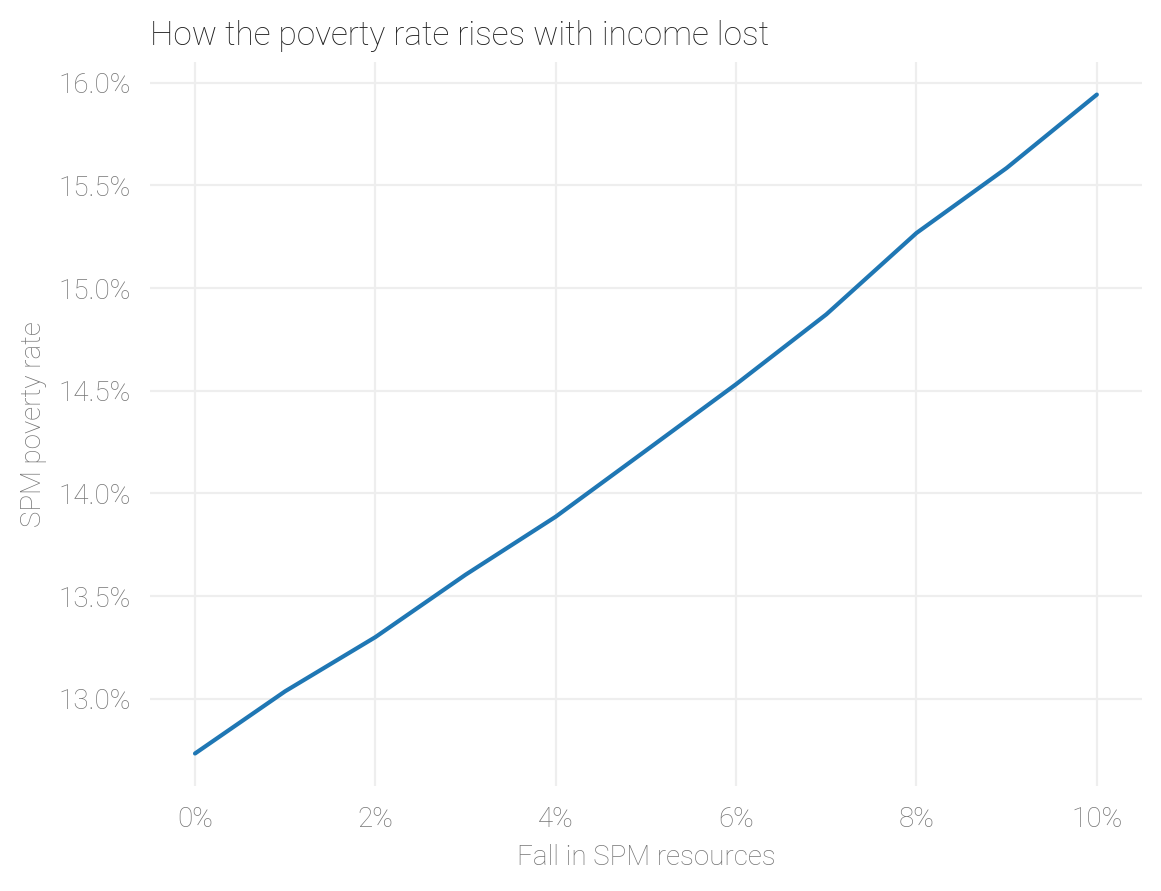

In [54]:
ax = cuts.pov_rate.plot()
plt.title('How the poverty rate rises with income lost', loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=1))
plt.xlabel('Fall in SPM resources')
plt.ylabel('SPM poverty rate')
plt.show()

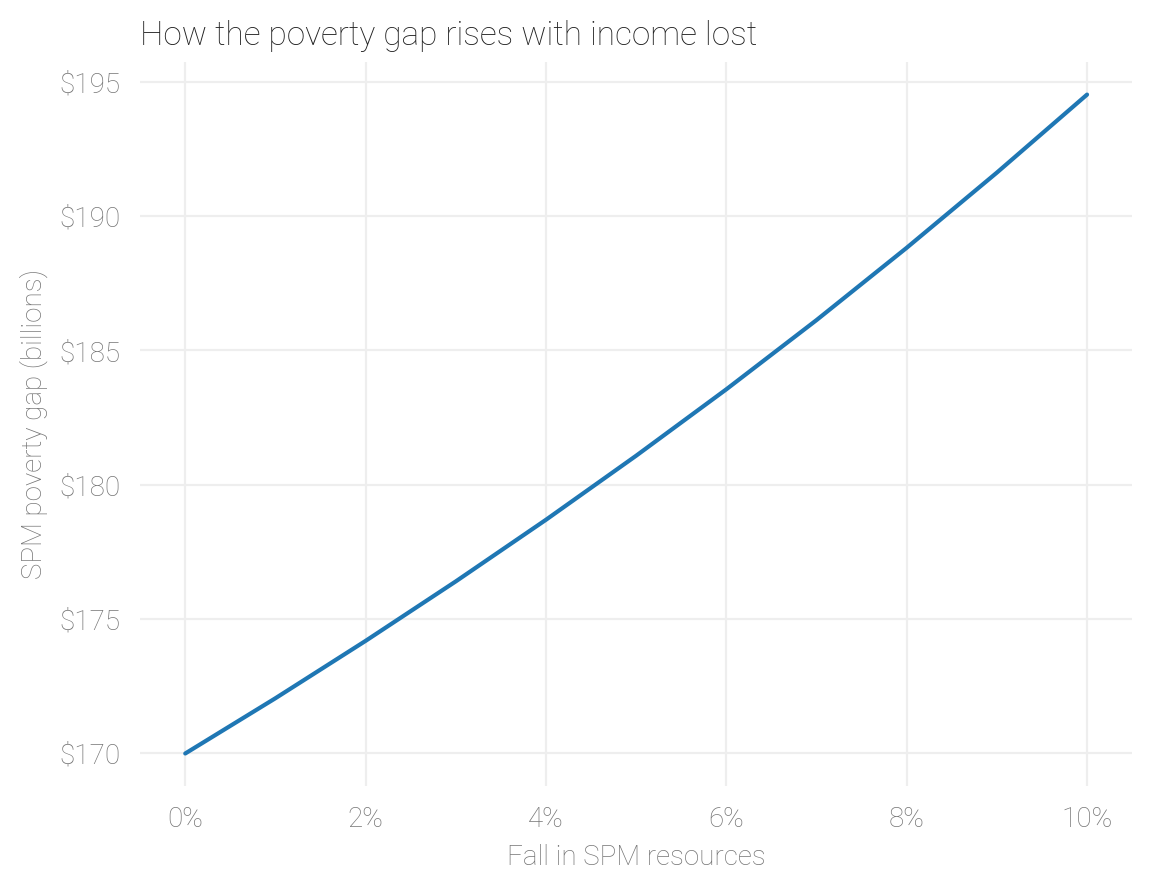

In [53]:
ax = cuts.pov_gap_b.plot()
plt.title('How the poverty gap rises with income lost', loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.xlabel('Fall in SPM resources')
plt.ylabel('SPM poverty gap (billions)')
plt.show()

Compared to baseline.

In [42]:
cuts - cuts.iloc[0]

,pov_rate,pov_gap_b,pov_m
0.00,0.000000,0.000000,0.000000
0.01,0.003032,2.058236,0.991927
0.02,0.005668,4.194937,1.854696
0.03,0.008708,6.409913,2.849103
0.04,0.011534,8.705166,3.773821
0.05,0.014754,11.090481,4.827511
0.06,0.017985,13.563987,5.884806
0.07,0.021385,16.142045,6.997185
0.08,0.025349,18.834945,8.294208
0.09,0.028515,21.635127,9.330175


In [43]:
cuts / cuts.iloc[0]

,pov_rate,pov_gap_b,pov_m
0.00,1.000000,1.000000,1.000000
0.01,1.023808,1.012108,1.023808
0.02,1.044515,1.024678,1.044515
0.03,1.068382,1.037708,1.068382
0.04,1.090577,1.051210,1.090577
0.05,1.115867,1.065242,1.115867
0.06,1.141243,1.079793,1.141243
0.07,1.167942,1.094959,1.167942
0.08,1.199072,1.110800,1.199072
0.09,1.223936,1.127273,1.223936


## With UBI

### Single amount

In [44]:
df.spm_numkidcitizens.sum()

209678.0

In [45]:
df.columns

Index(['prcitshp', 'a_age', 'marsupwt', 'spm_id', 'spm_numadults',
       'spm_numkids', 'spm_numper', 'spm_poor', 'spm_povthreshold',
       'spm_resources', 'spm_weight', 'w', 'spm_w', 'is_citizen', 'is_kid',
       'is_adult', 'is_kid_citizen', 'is_adult_citizen', 'spm_nu18', 'spm_n18',
       'spm_numkidcitizens', 'spm_numadultcitizens'],
      dtype='object')

In [46]:
ubi_pov_rate(0, 0, 6000, 6000)

0.037348301983918815

In [47]:
1 - ubi_pov(6000, 6000) / ubi_pov(0, 0)

NameError: name 'ubi_pov' is not defined

In [ ]:
ubi_pov(7800, 0)

In [ ]:
1 - ubi_pov(7800, 0) / ubi_pov(0, 0)

In [ ]:
ubi_cost(12000, 0) / 1e12

## Miscellaneous

In [ ]:
print_pov(df[df.is_citizen])

In [ ]:
print_pov(df[~df.is_citizen])